# Heart Attack Prediction

### Project Overview

Machine learning can potentially play a significant role in helping doctors and scientists predict heart disease. A person’s chance of having a heart disease includes many factors such as diabetes, high blood pressure, high cholesterol, abnormal heart rate, and age. In this sample, you will use AWS SageMaker to train a linear learner algorithm that can potentially predict the presence of heart disease.

Note: This is only a sample application and should not be considered as medical advice.

Generally, the data science project consists of seven steps which are problem definition, data collection, data preparation, data exploration, data modeling, model evaluation and model deployment.


#### Step 1: Problem Definition

This project is the capstone assignment for Udacity Machine Learning NanoDegree. It aims to model and predict the presence of heart disease in patients by using binary classification machine learning algorithm and a dataset of patient information, which can be found on Kaggle and UC Irvine's Machine Learning Repository.


#### Step 2: Data Collection

For this blog project, I decided to use the the heart disease UCI dataset taken from https://www.kaggle.com/ronitf/heart-disease-uci which is already a reprocessed data from UCI machine learning repository. This dataset have been taken back from 1988 and consisted of patients with admitted heart disease and chest pain symptoms from Cleveland.

The dataset has 14 attributes:

age: age in years.
sex: sex (1 = male; 0 = female).
cp: chest pain type (Value 0: typical angina; Value 1: atypical angina; Value 2: non-anginal pain; Value 3: asymptomatic).
trestbps: resting blood pressure in mm Hg on admission to the hospital.
chol: serum cholestoral in mg/dl.
fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false).
restecg: resting electrocardiographic results (Value 0: normal; Value 1: having ST-T wave abnormality; Value 2: probable or definite left ventricular hypertrophy).
thalach: maximum heart rate achieved.
exang: exercise induced angina (1 = yes; 0 = no).
oldpeak: ST depression induced by exercise relative to rest.
slope: the slope of the peak exercise ST segment (Value 0: upsloping; Value 1: flat; Value 2: downsloping).
ca: number of major vessels (0-3) colored by flourosopy.
thal: thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect).
target: heart disease (1 = no, 2 = yes).

#### Import libraries

Let's first import all the necessary libraries. I'll use numpy and pandas to start with.

For visualization, I will use pyplot subpackage of matplotlib, use rcParams to add styling to the plots and rainbow for colors. For implementing Machine Learning models, sagemaker libraries
For processing the data, I'll import a few libraries. To split the available dataset for testing and training, I'll use the train_test_split method. 

In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os

## Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 20,8
%matplotlib inline

# sagemaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer, json_deserializer


from sklearn.metrics import accuracy_score
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler


#### Import dataset

Now that we have all the libraries we will need, I can import the dataset and take a look at it. The dataset is stored in the file dataset.csv. I'll use the pandas read_csv method to read the dataset.

In [2]:
heart_data = pd.read_csv('data/heart.csv')

heart_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


The dataset is now loaded into the variable dataset. I'll just take a glimpse of the data using the desribe() and info() methods before I actually start processing and visualizing it.

In [3]:
heart_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [4]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


#### Step 3. Data Exploration

##### Understanding the data

Now, we can use visualizations to better understand our data and then look at any processing we might want to do.

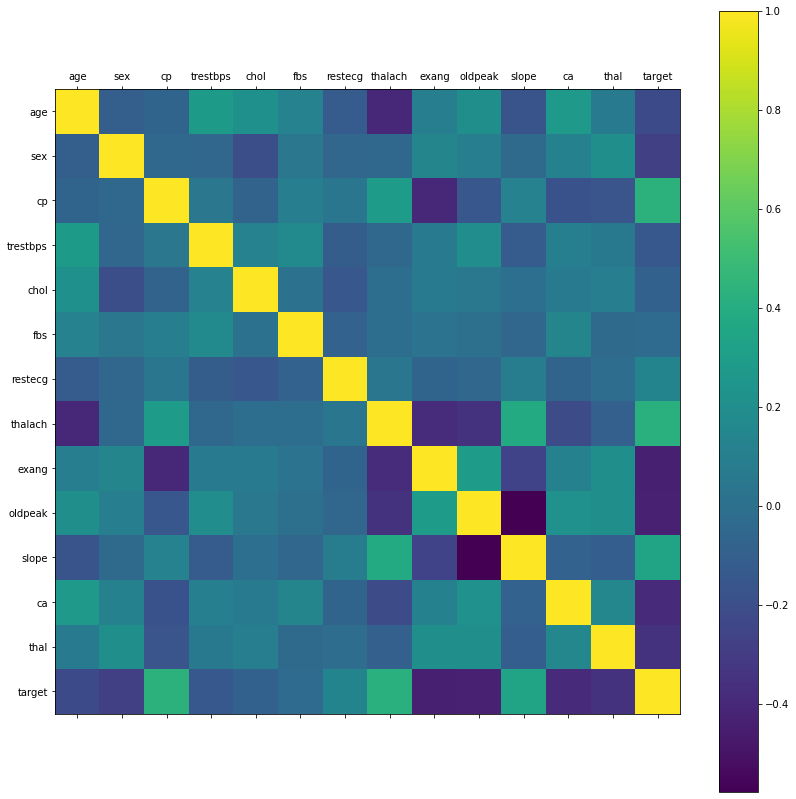

In [5]:
rcParams['figure.figsize'] = 20, 14
plt.matshow(heart_data.corr())
plt.yticks(np.arange(heart_data.shape[1]), heart_data.columns)
plt.xticks(np.arange(heart_data.shape[1]), heart_data.columns)
plt.colorbar()

Taking a look at the correlation matrix above, it's easy to see that a few features have negative correlation with the target value while some have positive. Next, I'll take a look at the histograms for each variable.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'cp'}>,
        <AxesSubplot:title={'center':'trestbps'}>],
       [<AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'fbs'}>,
        <AxesSubplot:title={'center':'restecg'}>,
        <AxesSubplot:title={'center':'thalach'}>],
       [<AxesSubplot:title={'center':'exang'}>,
        <AxesSubplot:title={'center':'oldpeak'}>,
        <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'ca'}>],
       [<AxesSubplot:title={'center':'thal'}>,
        <AxesSubplot:title={'center':'target'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

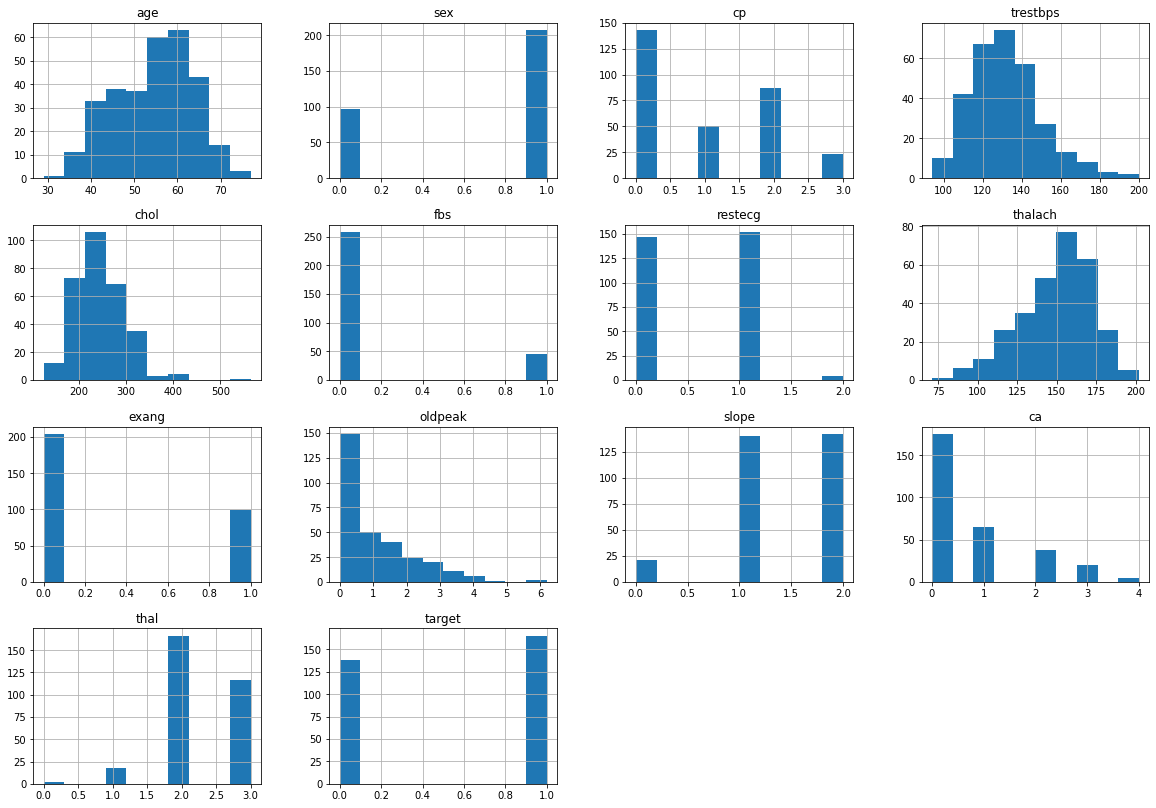

In [6]:
heart_data.hist()

Taking a look at the histograms above, I can see that each feature has a different range of distribution. Thus, using scaling before our predictions should be of great use. Also, the categorical features do stand out.

It's always a good practice to work with a dataset where the target classes are of approximately equal size. Thus, let's check for the same.

Text(0.5, 1.0, 'Count of each Target Class')

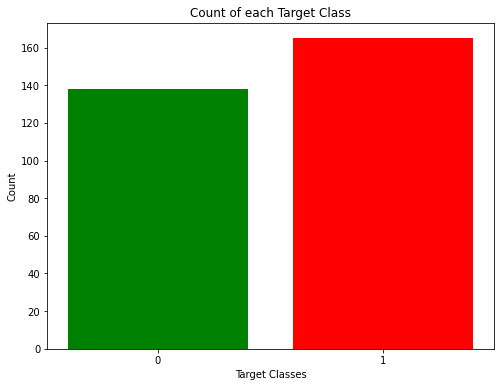

In [7]:
rcParams['figure.figsize'] = 8,6
plt.bar(heart_data['target'].unique(), heart_data['target'].value_counts(), color = ['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')

The two classes are not exactly 50% each but the ratio is good enough to continue without dropping/increasing our data.

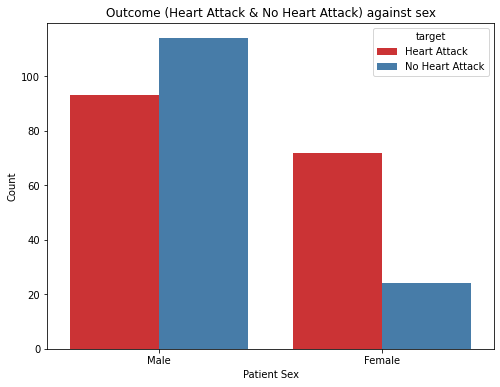

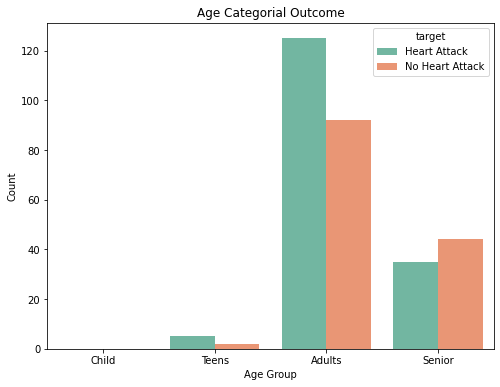

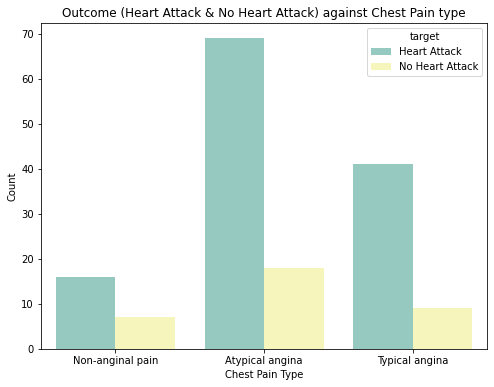

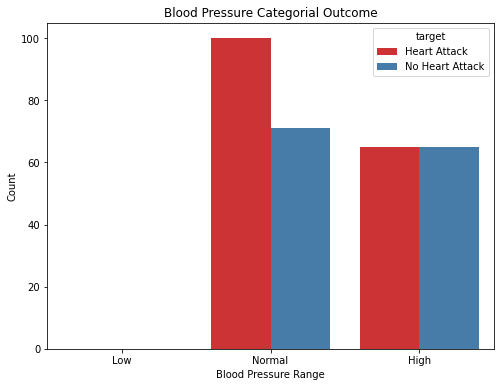

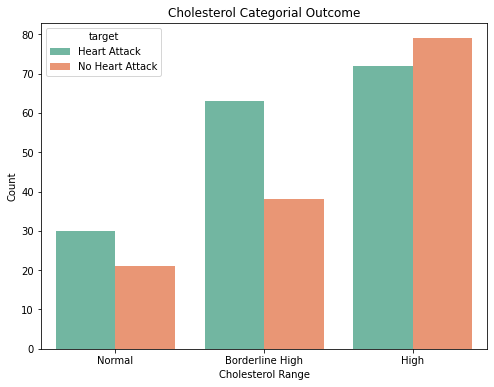

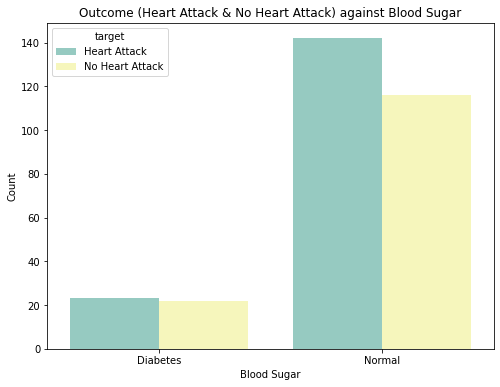

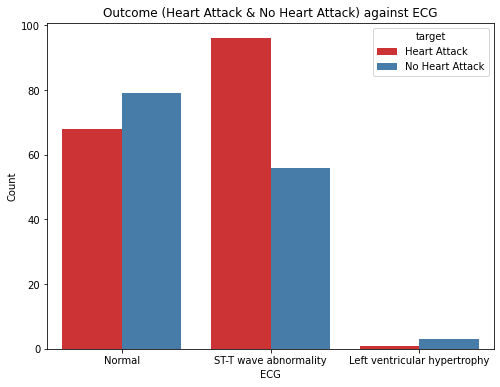

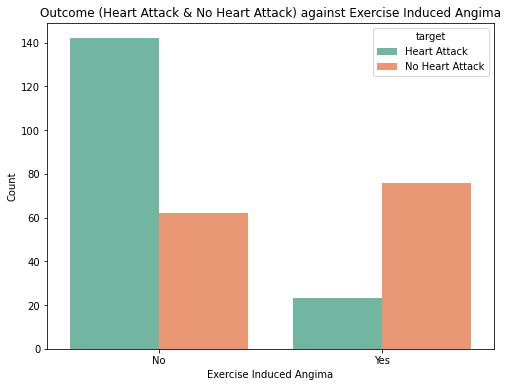

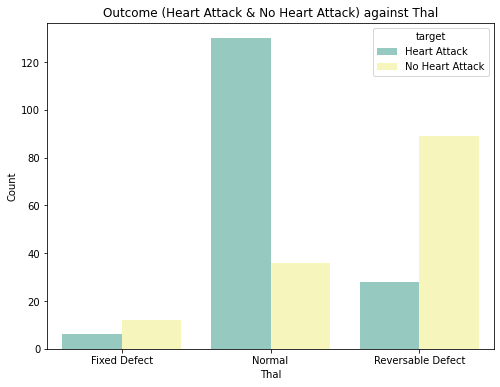

In [8]:
dum_data = heart_data.copy()

ctar = {1: "Heart Attack", 0: "No Heart Attack"}
dum_data.target = dum_data.target.map(ctar)

### Data Distribution against sex

csex = {1: "Male", 0: "Female"}
dum_data.sex = dum_data.sex.map(csex)

ax = sns.countplot(x='sex', hue='target', palette = 'Set1', data = dum_data)
ax.set(title = "Outcome (Heart Attack & No Heart Attack) against sex", xlabel = 'Patient Sex', ylabel = 'Count' )
plt.show()

### Data Distribution against age group

age_group = (0, 18, 35, 60, 100)
labels = ['Child', 'Teens', 'Adults', 'Senior']
dum_data.age = pd.cut(dum_data.age, age_group, labels = labels)

ax = sns.countplot(x='age', hue='target', palette = 'Set2', data = dum_data)
ax.set(title = "Age Categorial Outcome", xlabel = 'Age Group', ylabel = 'Count' )
plt.show()

### Data Distribution against Chest Pain Type

ccp = {1: "Typical angina", 2: "Atypical angina", 3: "Non-anginal pain", 4: "Asymptomatic"}
dum_data.cp = dum_data.cp.map(ccp)

ax = sns.countplot(x='cp', hue='target', palette = 'Set3', data = dum_data)
ax.set(title = "Outcome (Heart Attack & No Heart Attack) against Chest Pain type", xlabel = 'Chest Pain Type', ylabel = 'Count' )
plt.show()

### Data Distribution against Blood Pressure

bp_range = (60, 90, 130, 190)
labels = ['Low','Normal', 'High']
dum_data.trestbps = pd.cut(dum_data.trestbps, bp_range, labels=labels)

ax = sns.countplot(x='trestbps', hue = 'target', palette = 'Set1', data = dum_data)
ax.set(title = "Blood Pressure Categorial Outcome", xlabel = "Blood Pressure Range" , ylabel = "Count")
plt.show()

### Data Distribution against Cholesterol

chol_range = (0, 200, 240, 600)
labels = ['Normal', 'Borderline High', 'High']
dum_data.chol = pd.cut(dum_data.chol, chol_range, labels=labels)

ax = sns.countplot(x='chol', hue = 'target', palette = 'Set2', data = dum_data)
ax.set(title = "Cholesterol Categorial Outcome", xlabel = "Cholesterol Range" , ylabel = "Count")
plt.show()

### Data Distribution against Fasting Blood Sugar

cfbs = {1: "Diabetes", 0: "Normal"}
dum_data.fbs = dum_data.fbs.map(cfbs)

ax = sns.countplot(x='fbs', hue='target', palette = 'Set3', data = dum_data)
ax.set(title = "Outcome (Heart Attack & No Heart Attack) against Blood Sugar", xlabel = 'Blood Sugar', ylabel = 'Count' )
plt.show()

### Data Distribution against Resting ECG Results

cecg = {0: "Normal", 1: "ST-T wave abnormality", 2: "Left ventricular hypertrophy"}
dum_data.restecg = dum_data.restecg.map(cecg)

ax = sns.countplot(x='restecg', hue='target', palette = 'Set1', data = dum_data)
ax.set(title = "Outcome (Heart Attack & No Heart Attack) against ECG", xlabel = 'ECG', ylabel = 'Count' )
plt.show()

### Data Distribution against Exercise Induced Angima

cexang = {0: "No", 1: "Yes"}
dum_data.exang = dum_data.exang.map(cexang)

ax = sns.countplot(x='exang', hue='target', palette = 'Set2', data = dum_data)
ax.set(title = "Outcome (Heart Attack & No Heart Attack) against Exercise Induced Angima", xlabel = 'Exercise Induced Angima', ylabel = 'Count' )
plt.show()

### Data Distribution against Thal

cthal = {2: "Normal", 1: "Fixed Defect", 3: "Reversable Defect"}
dum_data.thal = dum_data.thal.map(cthal)

ax = sns.countplot(x='thal', hue='target', palette = 'Set3', data = dum_data)
ax.set(title = "Outcome (Heart Attack & No Heart Attack) against Thal", xlabel = 'Thal', ylabel = 'Count' )
plt.show()

Taking a look at the categorical counts above, we can see the number of occurences for each category.

#### Step 4. Data Preparation

After exploring the dataset, I observed that I need to convert some categorical variables into dummy variables and scale all the values before training the Machine Learning models. First, I'll use the get_dummies method to create dummy columns for categorical variables.

In [9]:
heart_data = pd.get_dummies(heart_data, columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])

Now, I will use the StandardScaler from sklearn to scale my dataset.

In [10]:
standardScaler = StandardScaler()
columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
heart_data[columns_to_scale] = standardScaler.fit_transform(heart_data[columns_to_scale])

In [11]:
heart_data.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,1,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0


#### Machine Learning

In the cells below, I'm creating the train/test data. I'll use train_test_split to split our dataset into training and testing datasets. And get train/test features and labels.

In [12]:
heart_data_y = heart_data.target
heart_data_X = heart_data.drop('target', axis=1)

# Split the data into the DataFrames train and test with test size 20%

train_X, test_X, train_y, test_y = sklearn.model_selection.train_test_split(heart_data_X, heart_data_y, test_size = 0.2)

train_X = train_X.reset_index(drop=True)
test_X = test_X.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

print('Train dataset size: ')
print(train_X.shape)

print('Test dataset size: ')
print(test_X.shape)

Train dataset size: 
(242, 30)
Test dataset size: 
(61, 30)


#### Uploading Training & Test files to S3

In [13]:
# store the current SageMaker session

session = sagemaker.Session()

# get IAM role

role = get_execution_role()
print(role)

arn:aws:iam::903656752510:role/service-role/AmazonSageMaker-ExecutionRole-20210409T134228


In [14]:
# get default bucket

bucket_name = session.default_bucket()
print(bucket_name)

sagemaker-us-east-1-903656752510


In [15]:
# define location to store model artifacts

prefix = 'heart_data'

output_path='s3://{}/{}/output'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-903656752510/heart_data/output


In [16]:
train_X.iloc[:5]

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,-0.260980,1.163746,0.999823,1.239897,0.138373,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,-0.040403,-0.663867,-1.125980,-1.602586,0.310912,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,1.172774,0.364165,0.690615,1.064975,0.310912,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0.621330,-0.378302,0.226803,-0.378132,1.518686,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.952197,-0.092738,1.618238,-0.771706,0.655990,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1


In [17]:
train_y.iloc[:5]

0    1
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [18]:
test_X.iloc[:5]

,age,trestbps,chol,thalach,oldpeak,sex_0,sex_1,cp_0,cp_1,cp_2,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,0.952197,0.478391,-0.990702,1.283627,-0.896862,1,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,1.724218,1.620649,0.439384,-1.646316,1.604955,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,-0.260980,0.135714,-0.874749,0.365287,-0.206705,0,1,0,1,0,...,1,0,1,0,0,0,0,0,1,0
3,1.172774,1.335085,0.439384,-0.072018,-0.206705,1,0,0,0,1,...,1,1,0,0,0,0,0,0,1,0
4,1.724218,1.392198,-0.024428,-0.290671,-0.896862,0,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0


In [19]:
test_y.iloc[:5]

0    1
1    0
2    1
3    1
4    1
Name: target, dtype: int64

In [20]:
# First we make sure that the local directory in which we'd like to store the training and test csv files exists.

data_dir = 'data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print("True")

In [21]:
# First, save the test data to test.csv in the data_dir directory.

pd.DataFrame(test_X).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

# Save the training data to train.csv in the data_dir directory

pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X)], axis = 1).to_csv(os.path.join(data_dir, 'train.csv'), header = False, index = False)


In [22]:
#test_X = train_X = val_X = train_y = val_y = None

In [23]:
# Upload the test.csv and train.csv files which are contained in data_dir to S3 using session.upload_data().

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir,'train.csv'), key_prefix=prefix)

train_location

's3://sagemaker-us-east-1-903656752510/heart_data/train.csv'

#### Step 5. Data Modeling

Now that we've uploaded your training data, it's time to define and train a model!

To begin with, we need to do some setup by making use of Docker containers.

In this notebook, we'll define and train the LinearLearner for binary classification, in which a line is separating two classes of data and effectively outputs labels; either 1 for data that falls above the line or 0 for points that fall on or below the line.


In [24]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner', "latest")

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_path,
                                       sagemaker_session=session)
linear.set_hyperparameters(feature_dim=30,
                           predictor_type='binary_classifier',
                           mini_batch_size=100)



The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Now that our model has been set up we simply need to attach the training dataset and then ask SageMaker to set up the computation.

In [25]:
from sagemaker.inputs import TrainingInput

s3_input_train = TrainingInput(s3_data=train_location, content_type='text/csv')

linear.fit({'train': s3_input_train})

2021-04-23 20:27:01 Starting - Starting the training job...
2021-04-23 20:27:25 Starting - Launching requested ML instancesProfilerReport-1619209620: InProgress
.........
2021-04-23 20:28:45 Starting - Preparing the instances for training......
2021-04-23 20:29:58 Downloading - Downloading input data......
2021-04-23 20:30:56 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/23/2021 20:31:01 INFO 139992882120512] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'ini

From the training logs, we can see the metrics of this model as :

('binary_classification_cross_entropy_objective', 0.31188186929245626)
('binary_classification_accuracy', 0.8884297520661157)
('binary_f_1.000', 0.898876404494382)
('precision', 0.8823529411764706)
('recall', 0.916030534351145)
('roc_auc_score', 0.939275153015611)

Best model found for hyperparameters: {"optimizer": "adam", "learning_rate": 0.1, "wd": 0.01, "l1": 0.0, "lr_scheduler_step": 100, "lr_scheduler_factor": 0.99, "lr_scheduler_minimum_lr": 1e-05}

#### Step 6. Model Deployment

After training, we have to deploy the trained model to create a predictor.

To deploy a trained model, we'll use <model>.deploy.

In [26]:
%%time

# deploy and create a predictor
# training_job = linear-learner-2021-04-21-17-57-00-733

predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------------!CPU times: user 365 ms, sys: 2.18 ms, total: 367 ms
Wall time: 10min 33s


#### Step 7. Model Evaluation

Once the model is deployed, we can see how it performs when applied to our test data.

The provided cell below, reads in the test data from s3 'test_location' path. The features are extracted from the test.csv file and labels are stored in test_y


In [27]:
test_data = pd.read_csv(test_location, header=None)
test_data_np = test_data.to_numpy().astype('float32')

test_data_np

array([[ 0.9521966 ,  0.47839126, -0.99070203, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.7242184 ,  1.6206493 ,  0.43938366, ...,  0.        ,
         0.        ,  1.        ],
       [-0.2609805 ,  0.13571383, -0.8747491 , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.73161894,  0.13571383, -0.23700823, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.40075245, -0.3783023 ,  1.0384736 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.06988599,  0.19282673,  0.07219949, ...,  0.        ,
         1.        ,  0.        ]], dtype=float32)

#### Determine the accuracy of your model

Using the deployed predictor to generate predicted, class labels for the test data. Comparing those to the true labels, test_y, and calculate the accuracy as a value between 0 and 1.0 that indicates the fraction of test data that the model classified correctly.

In [28]:
from sagemaker.predictor import csv_serializer, json_deserializer

#predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
#predictor.accept = 'application/json'
predictor.deserializer = json_deserializer


In [29]:
results = predictor.predict(test_data_np)

results

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'predictions': [{'score': 0.7736791372299194, 'predicted_label': 1},
  {'score': 0.053800247609615326, 'predicted_label': 0},
  {'score': 0.5773739814758301, 'predicted_label': 1},
  {'score': 0.9950822591781616, 'predicted_label': 1},
  {'score': 0.9111481308937073, 'predicted_label': 1},
  {'score': 0.001069080550223589, 'predicted_label': 0},
  {'score': 0.505685031414032, 'predicted_label': 0},
  {'score': 0.6943328380584717, 'predicted_label': 1},
  {'score': 0.9580315947532654, 'predicted_label': 1},
  {'score': 0.9497296810150146, 'predicted_label': 1},
  {'score': 0.7339828014373779, 'predicted_label': 1},
  {'score': 0.8932768106460571, 'predicted_label': 1},
  {'score': 0.05544140189886093, 'predicted_label': 0},
  {'score': 0.8613054752349854, 'predicted_label': 1},
  {'score': 0.8125512003898621, 'predicted_label': 1},
  {'score': 0.07620199769735336, 'predicted_label': 0},
  {'score': 0.9900471568107605, 'predicted_label': 1},
  {'score': 0.9890356659889221, 'predicted_la

In [30]:
preds = []

for each in results['predictions']:
    preds.append(each['predicted_label'])

preds = np.array(preds)
    
test_labels = test_y.to_numpy()

test_labels, preds

(array([1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1]),
 array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1]))

In [31]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(test_labels, test_preds, verbose=True):
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels == 1, test_preds == 1).sum()
    fp = np.logical_and(test_labels == 0, test_preds == 1).sum()
    tn = np.logical_and(test_labels == 0, test_preds == 0).sum()
    fn = np.logical_and(test_labels == 1, test_preds == 0).sum()

    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    print(recall, precision, accuracy)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


In [32]:
print('Metrics for simple, LinearLearner.\n')

# get metrics for linear predictor
metrics = evaluate(test_labels,
                   preds) # verbose means we'll print out the metrics

Metrics for simple, LinearLearner.

0.9705882352941176 0.868421052631579 0.9016393442622951
prediction (col)   0   1
actual (row)            
0                 22   5
1                  1  33

Recall:     0.971
Precision:  0.868
Accuracy:   0.902



In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, preds)

0.9016393442622951

Out of 61 data in test dataset, 55 are predicted correctly, hence the model get 90% of accuracy with 6 input classified incorrectly - false negative & false positive.

True Positives: 33, False Positives: 5, False Negatives: 1, True Negatives: 22

#### Clean up Resources

After done evaluating your model, deleting model endpoint.


In [34]:
predictor.delete_endpoint()

#### Deleting S3 bucket

When completely done with training and testing models, delete the entire S3 bucket.

In [35]:
# deleting bucket

bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '4T9Q9Q5MR8W0AZCE',
   'HostId': 'rUW/D0EQs8eN9b5uuJd9fNSiDKV9AyH31Ah0syZDK76E0SGxGcybea8leWeJZjU4TKW5+yykTUU=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'rUW/D0EQs8eN9b5uuJd9fNSiDKV9AyH31Ah0syZDK76E0SGxGcybea8leWeJZjU4TKW5+yykTUU=',
    'x-amz-request-id': '4T9Q9Q5MR8W0AZCE',
    'date': 'Fri, 23 Apr 2021 20:46:33 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'heart_data/output/linear-learner-2021-04-23-20-27-00-707/rule-output/ProfilerReport-1619209620/profiler-output/profiler-reports/BatchSize.json'},
   {'Key': 'heart_data/output/linear-learner-2021-04-23-20-27-00-707/rule-output/ProfilerReport-1619209620/profiler-output/profiler-reports/Dataloader.json'},
   {'Key': 'heart_data/output/linear-learner-2021-04-23-20-27-00-707/profiler-output/system/incremental/2021042320/1619209800.algo-1.json'},
 